# Задание: Многовидовая 3D-реконструкция
**Цель:** Восстановить трёхмерное облако точек по трём проекциям с неизвестных ракурсов.

**Срок:** мы принимаем решения до 23:59 6 июня.

# Входные данные
Вам дан список из трёх проекций (`data.pth`), а также массив цветов точек для удобства визуализации (`rgbs.pth`). Как можно видеть, каждый ракурс содержит лишь часть точек в облаке, а вашей целью будет совместить все эти части, получив трёхмерное облако точек.

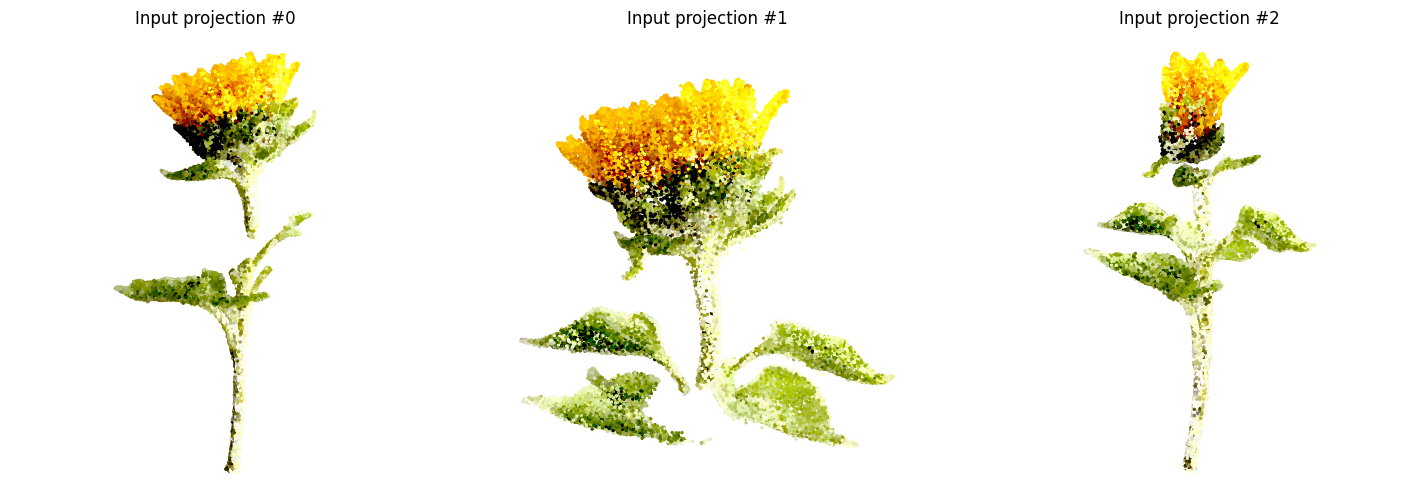

In [1]:
import torch
import matplotlib.pylab as plt

projections = torch.load('data.pth')
rgbs = torch.load('rgbs.pth')

fig, axes = plt.subplots(1, 3, figsize=(18,6))
for n_camera, (d, ax) in enumerate(zip(projections,  axes.flatten())):
    xs, ys = d['coordinates'].T
    indices = d['ids']
    ax.scatter(xs, ys, c=rgbs[indices], s=2.)
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(f'Input projection #{n_camera}')

Каждая проекция получена с неизвестного ракурса с помощью пинхол камеры с фокусным расстоянием 50мм, матрица внутренних параметров имеет следующий вид:

```python
# параметры объектива указывают в миллиметрах, а размер сенсора соответствет ширине кадра плёнки
f = 50
sensor_size = 36
# по ним строим матрицу внутренних параметров
K = torch.tensor([
    [2 * f / sensor_size, 0.0, 0.0],
    [0.0, 2 * f / sensor_size, 0.0],
    [0.0,                 0.0, 1.0]
])
```

Каждая проекция задана словарём. Поле `ids` содержит массив с номерами точек в исходном облаке (по ним можно найти соответствия между парой ракурсов), а поле `coordinates` неоднородные координаты в плоскости сенсора. Каждая точка видна как минимум с двух ракурсов.

```python
projection_example = {
    'ids': torch.tensor([0, 1, 2], dtype=torch.int64),
    'coordinates': torch.tensor([[0.1, 0.2], [0.2, 0.3], [0.3, 0.4]], dtype=torch.float32)
}
```

# Формат решения

Решение должно состоять из двух компонент:
1. Массив с реконструкцией исходного трёхмерного облака точек,
2. Отчёт в формате (PDF/Jupyter/Python/Markdown), с подробным описанием вашего метода и его реализацией.

## Облако точек

*Массив* будет использован для автоматизации проверки, но оценка за задание будет определяться в первую очередь на основе отчёта.
Ожидаемый формат массива - тензор размера $(N, 3)$. 
```python
solution_example = torch.tensor([[0.1, 0.2, 0.0], [0.2, 0.3, 0.0], [0.3, 0.4, 0.0]], dtype=torch.float32)
```
Масштаб облака точек должен быть выбран исходя из предположения, что расстояние между первой и второй камерой равно *(условной)* единице.

## Отчёт

Вы свободны выбирать свой путь решения, но присланное решение не должно опираться на внешние реализации алгоритмов поиска фундаментальной матрицы, PnP, триангуляции и подобных. Иными словами, решение может использовать методы из библиотек torch`/`numpy, а более сложные алгоритмы должны быть реализованы внутри.

Для отладки и упрощения проверки рекомендуем включить в отчёт визуализации и тесты промежуточных шагов с пояснениями. Также полезной может оказаться визуализация облака точек:
```python
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([pcd])
```

# Итак, отчёт

Инициализируем необходимые библиотеки

In [2]:
import torch
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Задаём матрицу внутренних параметров, предполагая, что размер сенсора - 36мм, а фокусное расстояние - 50 мм

In [3]:
f = 50
sensor_size = 36
K = torch.tensor([
    [2 * f / sensor_size, 0.0, 0.0],
    [0.0, 2 * f / sensor_size, 0.0],
    [0.0, 0.0, 1.0]
])

Теперь загрузим (ещё раз) данные о проекциях и цветах и выберем **первые две проекции** - пока что будем работать с ними.

In [4]:
projections = torch.load('data.pth')
rgbs = torch.load('rgbs.pth')

proj0, proj1 = projections[0:2]
common_ids01, idx0, idx1 = np.intersect1d(proj0['ids'], proj1['ids'], return_indices=True)
p0 = proj0['coordinates'][idx0]
p1 = proj1['coordinates'][idx1]

**Теперь перед нами задача - восстановить относительное положение камер по двум проекциям, а также восстановить точки в пространстве:**
1. Нормализуем пиксельные координаты
2. Оценим эссенциальную матрицу $E$
3. Находим возможные комбинации $(R, t)$ и определяем корректную позу
4. Восстанавливаем точки в пространстве с помощью триангуляции

Для этого сначала необходимо преобразовать пиксельные координаты в нормализованные координаты камеры:
* сначала переходим от декартовых координат к однородным (добавляем третью компоненту, равную 1)
* каждую точку умножаем слева на $K^{-1}$ и получаем нормализованные координаты камеры
* в конце возвращаемся от однородных координат к декартовым (отбрасываем добавленную на первом шаге компоненту, равную 1)

In [5]:
def normalize_points(p, K):
    p_h = torch.cat([p, torch.ones_like(p[:, :1])], dim=1)
    return (torch.inverse(K) @ p_h.T).T[:, :2]


p0_norm = normalize_points(p0, K)
p1_norm = normalize_points(p1, K)

Следующий шаг - получить эссенциальную матрицу $E$, которая задаёт геометрическое соотношение между двумя камерами, снимающими одну и ту же сцену.

Для неё выполнено $p_1^{T} E p_0 = 0$, где $p_0$ и $p_1$ - нормализованные координаты.

Для определения матрицы $E$ используем алгоритм восьми точек:
* формируем матрицу $A \in \mathbb{R}^{N \times 9}$ из попарных произведений элементов множеств $\{x_1, y_1, 1\}$ и $\{x_0, y_0, 1\}$
* решение $A \cdot vec(E) = 0$ находим через SVD как вектор, соответствующий наименьшему сингулярному значению (где $vec(E)$ - вектор из 9 элементов матрицы $E$)
* $[x_1^{i} x_0^{i},\ x_1^{i} y_0^{i},\ x_1^{i},\ y_1^{i} x_0^{i},\ y_1^{i} y_0^{i},\ y_1^{i},\ x_0^{i},\ y_0^{i},\ 1] \cdotp
\begin{bmatrix} e_{11} \\ e_{12} \\ e_{13} \\ e_{21} \\ e_{22} \\ e_{23} \\ e_{31} \\ e_{32} \\ e_{33} \end{bmatrix} = 0$ - уравнение для одной точки i
* полученная матрица приводится к рангу 2 (зануляем наименьшее сингулярное значение)

In [6]:
def essential_matrix(p0_norm, p1_norm):
    x0, y0 = p0_norm.T
    x1, y1 = p1_norm.T
    A = torch.stack([x1 * x0, x1 * y0, x1, y1 * x0, y1 * y0, y1, x0, y0, torch.ones_like(x0)], dim=1)

    _, _, V = torch.linalg.svd(A)
    E = V[-1].reshape(3, 3)

    U, S, Vt = torch.linalg.svd(E)
    S = torch.diag(torch.tensor([S[0], S[1], 0.0]))
    return U @ S @ Vt


E = essential_matrix(p0_norm, p1_norm)

Теперь определим положение второй камеры относительно первой - найдём возможные матрицы поворота $R$ и вектора сдвига $t$, выберем из них лучшую пару и вернём соответствующие точки в пространстве:
* сначала из эссенциальной матрицы $E$ с помощью SVD получаем 4 возможных пары $(R, t)$
* для каждой комбинации строим проекционную матрицу $P_1 = [R \mid t]$ (при этом $P_0 = [I \mid 0]$ зафиксирована)
* затем для каждой комбинации выполняем триангуляцию для каждой пары координат одной точки решаем систему $A \cdotp X = 0$ через SVD, $X$ - точка в однородных координатах
* из 4 комбинаций возвращаем ту, при которой наибольшее число точек оказывается перед обеими камерами, а также соответствующие точки в пространстве

In [7]:
def triangulate_point(p0, p1, P0, P1):
    A = torch.stack([p0[0] * P0[2] - P0[0], p0[1] * P0[2] - P0[1], p1[0] * P1[2] - P1[0], p1[1] * P1[2] - P1[1]])
    _, _, V = torch.linalg.svd(A)
    return V[-1][:3] / V[-1][3]

def triangulate_points(p0, p1, P0, P1):
    return torch.stack([triangulate_point(p0[i], p1[i], P0, P1) for i in range(p1.shape[0])])

def recover_pose_from_essential(E, p0, p1):
    U, _, Vt = torch.linalg.svd(E)
    if torch.det(U @ Vt) < 0:
        Vt = -Vt
    W = torch.tensor([[0.0, -1.0, 0.0], [1.0,  0.0, 0.0], [0.0, 0.0, 1.0]])
    poses = [(U @ W @ Vt,  U[:, 2]), (U @ W @ Vt, -U[:, 2]), (U @ W.T @ Vt,  U[:, 2]), (U @ W.T @ Vt, -U[:, 2])]

    mx = -1
    best_R, best_t, best_points = None, None, None
    P0 = torch.cat([torch.eye(3), torch.zeros(3, 1)], dim=1)

    for R, t in poses:
        P1 = torch.cat([R, t.view(-1, 1)], dim=1)
        points = triangulate_points(p0, p1, P0, P1)
        z1 = points[:, 2]
        z2 = (R @ points.T + t.view(-1, 1)).T[:, 2]
        cur = ((z1 > 0) & (z2 > 0)).sum()
        if cur > mx:
            mx = cur
            best_R, best_t, best_points = R, t, points

    return best_R, best_t, best_points


R1, t1, points01 = recover_pose_from_essential(E, p0_norm, p1_norm)

Теперь отмасштабируем облако точек так, чтобы расстояние между первой и второй камерой равно *(условной)* единице.

In [8]:
scale = torch.norm(t1)
points01 /= scale
t1 /= scale

Посмотрим, все ли точки мы восстановили:

In [9]:
print(f"Количество общих точек: {common_ids01.shape[0]}")
print(f"Количество восстановленных точек: {points01.shape[0]}")

Количество общих точек: 37502
Количество восстановленных точек: 37502


Отлично, мы восстановили все общие точки проекций 0 и 1! Теперь создадим массив для всех точек, положим туда восстановленные и посмотрим на промежуточный результат.

In [10]:
points = torch.full((rgbs.shape[0], 3), float('nan'))
points[common_ids01] = points01

# Визуализация
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(points01)
# pcd.colors = o3d.utility.Vector3dVector(rgbs[common_ids01])
# o3d.visualization.draw_geometries([pcd])

**Получилось красиво!**

Следующий шаг последний - добавить третью камеру, определить её положение относительно первых двух и восстановить все оставшиеся точки:
* используем `solvePnP` для нахождения третьей камеры $(R_2, t_2)$ по уже восстановленным в пространстве точкам и их проекциям третьей камеры
* получаем проекционные матрицы `P0`, `P1`, `P2` для всех трёх камер
* для невосстановленных точек берём их проекцию на третью камеру и на первую/вторую камеру (такая существует по условию)
* с помощью триангуляции и двух проекций восстанавливаем точку в пространстве

In [11]:
from cv2 import solvePnP, Rodrigues

proj2 = projections[2]
known_mask2 = ~torch.isnan(points[proj2['ids'], 0])
known_ids2, unknown_ids2 = proj2['ids'][known_mask2], proj2['ids'][~known_mask2]

rvec, tvec = solvePnP(points[known_ids2].cpu().numpy(), proj2['coordinates'][known_mask2].cpu().numpy(), K.cpu().numpy(), distCoeffs=np.zeros(5))[1:]
R, _ = Rodrigues(rvec)
R2, t2 = torch.from_numpy(R).float(), torch.from_numpy(tvec).view(-1).float()

P0 = K @ torch.cat([torch.eye(3), torch.zeros(3, 1)], dim=1)
P1 = K @ torch.cat([R1, t1.view(-1, 1)], dim=1)
P2 = K @ torch.cat([R2, t2.view(-1, 1)], dim=1)

for pid in unknown_ids2:
    for proji, Pi in zip([proj0, proj1], [P0, P1]):
        if pid in proji['ids']:
            pi = proji['coordinates'][proji['ids'] == pid][0]
            p2 = proj2['coordinates'][proj2['ids'] == pid][0]
            points[pid] = triangulate_point(pi, p2, Pi, P2)
            break

Посмотрим, получилось ли восстановить все точки:

In [12]:
print(f"Количество невосстановленных точек: {points[:, 0].isnan().sum()}")

Количество невосстановленных точек: 0


Отлично, все точки восстановлены! Посмотрим на результат:

In [13]:
# Визуализация
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(points)
# pcd.colors = o3d.utility.Vector3dVector(rgbs)
# o3d.visualization.draw_geometries([pcd])

**Вау, классно, получилось очень красиво!**

Значит, мы сделали всё правильно!

Однако есть одно "но" - мы использовали cv2 для определения $(R_2, t_2)$, а так делать нельзя по условию. Поэтому напишем свой PnP, и повторим решение.

Прежде всего оставим только точки, которые были получены с помощью первых двух проекций.

In [14]:
points = torch.full((rgbs.shape[0], 3), float('nan'))
points[common_ids01] = points01

**Для решения задачи PnP будем использовать метод DLT** (мы его уже использовали в алгоритме восьми точек, когда оценивали эссенциальную матрицу $E$):
* нормализуем пиксельные координаты
* формируем матрицу $A \in \mathbb{R}^{2N \times 12}$ для DLT
* решение $A \cdot s = 0$ находим через SVD как вектор, соответствующий наименьшему сингулярному значению
* $\begin{bmatrix} X_i & Y_i & Z_i & 0 & 0 & 0 & -x_i X_i & -x_i Y_i & -x_i Z_i & 1 & 0 & -x_i \\
0 & 0 & 0 & X_i & Y_i & Z_i & -y_i X_i & -y_i Y_i & -y_i Z_i & 0 & 1 & -y_i \end{bmatrix} \cdot
\begin{bmatrix} r_{11} \\ r_{12} \\ r_{13} \\ r_{21} \\ r_{22} \\ r_{23} \\ r_{31} \\ r_{32} \\ t_{33} \\ t_{11} \\ t_{12} \\ t_{13} \end{bmatrix} = 0$ - уравнение для одной точки i
* тогда первые 9 значений вектора `s` будут соответствовать матрице `R_approx`, а оставшиеся 3 значения - вектору `t_approx`
* поскольку `R_approx` может не быть ортогональной, приводим её к ближайшей ортогональной матрице `R` с определителем 1
* подставляем известные компоненты `R` и координаты 3D-точек в уравнение камеры и решаем линейную систему:
* $\begin{bmatrix} 1 & 0 & -x_i \\ 0 & 1 & -y_i \end{bmatrix} \cdotp t = \begin{bmatrix} x_i r_3^T W_i - r_1^T W_i \\ y_i r_3^T W_i - r_2^T W_i \end{bmatrix},
\space W_i = (X_i, Y_i, Z_i)^T$ - уравнение для одной точки i
* возвращаем полученные `R` и `t`

*Остальной код остался без изменений.*

In [15]:
def solve_pnp_dlt(points_3d, points_2d, K):
    norm_pts = normalize_points(points_2d, K)
    x, y = norm_pts.T
    X, Y, Z = points_3d.T

    A = torch.zeros((2 * points_3d.shape[0], 12))
    for i in range(points_3d.shape[0]):
        A[2 * i] = torch.tensor([X[i], Y[i], Z[i], 0, 0, 0, -x[i] * X[i], -x[i] * Y[i], -x[i] * Z[i], 1, 0, -x[i]])
        A[2 * i + 1] = torch.tensor([0, 0, 0, X[i], Y[i], Z[i], -y[i] * X[i], -y[i] * Y[i], -y[i] * Z[i], 0, 1, -y[i]])

    _, _, V = torch.svd(A)
    R_approx = V[:9, -1].view(3, 3)
    U, _, V = torch.svd(R_approx)
    R = U @ V.T
    if torch.det(R) < 0:
        R = -R

    A, b = [], []
    for i in range(points_3d.shape[0]):
        R1X, R2X, R3X = (R @ points_3d[i]).tolist()
        A += [[1, 0, -x[i]], [0, 1, -y[i]]]
        b += [x[i] * R3X - R1X, y[i] * R3X - R2X]
    t = torch.linalg.lstsq(torch.tensor(A), torch.tensor(b).unsqueeze(1)).solution.squeeze()
    return R, t


points = torch.full((rgbs.shape[0], 3), float('nan'))
points[common_ids01] = points01

proj2 = projections[2]
known_mask2 = ~torch.isnan(points[proj2['ids'], 0])
known_ids2, unknown_ids2 = proj2['ids'][known_mask2], proj2['ids'][~known_mask2]

R2, t2 = solve_pnp_dlt(points[known_ids2], proj2['coordinates'][known_mask2], K)

P0 = K @ torch.cat([torch.eye(3), torch.zeros(3, 1)], dim=1)
P1 = K @ torch.cat([R1, t1.view(-1, 1)], dim=1)
P2 = K @ torch.cat([R2, t2.view(-1, 1)], dim=1)

for pid in unknown_ids2:
    for proji, Pi in zip([proj0, proj1], [P0, P1]):
        if pid in proji['ids']:
            pi = proji['coordinates'][proji['ids'] == pid][0]
            p2 = proj2['coordinates'][proj2['ids'] == pid][0]
            points[pid] = triangulate_point(pi, p2, Pi, P2)
            break

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(rgbs)
o3d.visualization.draw_geometries([pcd])

Посмотрим, получилось ли восстановить все точки:

In [16]:
print(f"Количество невосстановленных точек: {points[:, 0].isnan().sum()}")

Количество невосстановленных точек: 0


Отлично! Теперь сохраним точки:

In [17]:
torch.save(points, 'solution.pth')

В конце посмотрим на итоговое решение:

In [19]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(rgbs)
o3d.visualization.draw_geometries([pcd])